In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            runtime = to_seconds(end) - to_seconds(start)
            if runtime < 0: # we crossed into the next day
                to_midnight = 60*60*24 - to_seconds(start)
                runtime = to_midnight + to_seconds(end)
            r.append(runtime)
    return r

# Normalize to RPCs for each cluster size

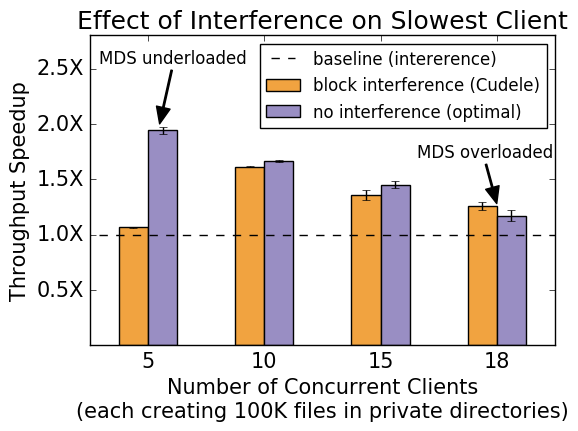

In [6]:
baselinedir = "../../baseline-creates/results-cloudlab-clients"
mean = pd.DataFrame(columns=["block interference (Cudele)", "no interference (optimal)"])
stds = pd.DataFrame(columns=["block interference (Cudele)", "no interference (optimal)"])
clients = [5, 10, 15, 18]
for i in clients:
    isolated = []; interfer = []
    for run in [0, 1, 3]:
        dname = "../results-cloudlab-clients" + str(i) + "-log-run" + str(run)
        isojob = parse_mdtest(glob.glob(dname + "/*isolated*"))
        intjob = parse_mdtest(glob.glob(dname + "/*interfere*"))
        if len(isojob) != 0 and len(intjob) != 0:
            isolated.append(np.max(isojob))
            interfer.append(np.max(intjob))
    baseline = np.max(parse_mdtest(glob.glob(baselinedir + str(i) + "/*interfere*")))
    mean.loc[len(mean)] = [np.max(baseline/interfer), np.max(baseline/isolated)]
    stds.loc[len(stds)] = [np.std(baseline/interfer), np.std(baseline/isolated)]

    font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
ax.plot([-4, 5], [1, 1], color='black', ls='--', label='baseline (intererence)')
mean.plot.bar(ax=ax, yerr=stds, color=['#f1a340', '#998ec3', 'white'])

ax.set_title("Effect of Interference on Slowest Client")
ax.set_ylabel("Throughput Speedup")
ax.set_xlabel("Number of Concurrent Clients\n(each creating 100K files in private directories)")
ax.set_xticklabels(clients, rotation=0)
ax.legend(fontsize=12, ncol=1, loc='upper right')
ax.set_ylim(0, 2.8)
labels = ['{:3.1f}X'.format(x) for x in ax.get_yticks()]
labels[0] = ""; labels[len(labels)-1] = "";
ax.set_yticklabels(labels)
arrw = dict(facecolor='black', headwidth=10, width=1, shrink=1)
args = {'horizontalalignment': 'center', 'fontsize': 12, 'arrowprops': arrw}
ax.annotate("MDS underloaded", xy=(0.1, 2), xytext=(0.21, 2.55), **args)
ax.annotate("MDS overloaded", xy=(3, 1.28), xytext=(2.9, 1.7), **args)
fig.savefig('../../../paper/graphs/block-allow.png', bbox_inches='tight', dpi=400)

# Normalize to raw hardware speed

In [ ]:
baselinedir = "../../baseline-creates/results-cloudlab-clients"
norm = np.mean(parse_mdtest(glob.glob(baselinedir + "1/*isolated*")))
mean = pd.DataFrame(columns=["block interference", "isolated"])
stds = pd.DataFrame(columns=["block interference", "isolated"])
clients = [5, 10, 15]
for i in clients:
    isolated = []; interfer = []
    for run in [0, 1, 3]:
        dname = "../results-cloudlab-clients" + str(i) + "-log-run" + str(run)
        isojob = parse_mdtest(glob.glob(dname + "/*isolated*"))
        intjob = parse_mdtest(glob.glob(dname + "/*interfere*"))
        if len(isojob) != 0 and len(intjob) != 0:
            isolated.append(np.max(isojob))
            interfer.append(np.max(intjob))
    baseline = np.max(parse_mdtest(glob.glob(baselinedir + str(i) + "/*interfere*")))
    mean.loc[len(mean)] = [np.max(interfer/norm), np.max(isolated/norm)]
    stds.loc[len(stds)] = [np.std(interfer/norm), np.std(isolated/norm)]

    font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
ax.plot([-4, 5], [1, 1], color='black', ls='--', label='baseline: 1 client\n(' + str(int(round(100000/norm))) + ' creates/sec)') 
mean.plot.bar(ax=ax, yerr=stds, color=['#f1a340', '#998ec3', 'white'])

ax.set_title("Effect of Interference on Slowest Client")
ax.set_ylabel("Throughput Overhead")
ax.set_xlabel("Number of Concurrent Clients\n(each creating 100K files in private directories)")
ax.set_xticklabels(clients, rotation=0)
ax.legend(fontsize=12, ncol=1, loc='upper left')
labels = ['{:3.0f}X'.format(x) for x in ax.get_yticks()]
labels[0] = ""; labels[len(labels)-1] = "";
ax.set_yticklabels(labels)
#arrw = dict(facecolor='black', headwidth=0.5, width=0.5, shrink=1)
#args = {'horizontalalignment': 'center', 'fontsize': 12, 'arrowprops': arrw}
#ax.annotate("baseline: 1 client\n(513 creates/sec)", xy=(0.5, 1), xytext=(0.3, 8), **args)
#fig.savefig('../../../paper/graphs/block-allow.png', bbox_inches='tight', dpi=400)
print "baseline=98000/runtime=98000/" + str(norm) + "=" + str(98000/norm)